In [53]:
import os 
from Bio.PDB import PDBParser, PPBuilder, is_nucleic, is_aa
from Bio.Data.IUPACData import protein_letters_3to1_extended
import warnings 
import json
import random
import numpy as np

warnings.filterwarnings("ignore")
root_dir = '.'

In [3]:
amino_acids = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

nucleotides = {
    'DA': 'A', 'DC': 'C', 'DG': 'G', 'DU': 'U', 'DT': 'T'
}

def extract_seq(pdb_file_path):
    prot_dict = {}
    prot_sequence = ''
    rna_sequence = ''
    rna_dict = {}
    res_num = 0
    res_count = 0    

    with open(pdb_file_path, 'r') as file:
        for line in file:
            if line[:4]==("ATOM"):
                residue_name = line[17:20].strip()
                atom_name = line[12:16].strip()
                res_num = int(line[22:26].strip())
                chain_id = line[21:22].strip()
                if atom_name == "O5'":
                    rna_sequence += residue_name
                elif atom_name == "CA":
                    res_count += 1

                    if  not res_num == res_count:
                        gap = res_num - res_count
                        #print("Gap in chain %s between residues %d and %d" % (chain_id, res_count, res_num))
                        prot_sequence += '-' * (gap)
                        pass
                    if is_aa(residue_name):
                        prot_sequence += amino_acids[residue_name]
                    res_count = res_num

            elif line[:3] == 'TER':
                if len(rna_sequence) > 0:
                    rna_dict[chain_id] = rna_sequence.replace('D', '')
                    rna_sequence = ''
                elif len(prot_sequence) > 0:
                    prot_dict[chain_id] = prot_sequence
                    prot_sequence = ''
                res_count = 0
                pass

        if len(rna_sequence) > 0:
            rna_dict[chain_id] = rna_sequence.replace('D', '')
        if len(prot_sequence) > 0:
            prot_dict[chain_id] = prot_sequence


    return rna_dict, prot_dict

In [3]:
def extract_binding_site(PDB_file):
    pass
def vectorize(site_list):
    pass

In [44]:
codon_table = {
    'A': ['GCU', 'GCC', 'GCA', 'GCG'],        # Alanine
    'R': ['CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],  # Arginine
    'N': ['AAU', 'AAC'],                      # Asparagine
    'D': ['GAU', 'GAC'],                      # Aspartic Acid
    'C': ['UGU', 'UGC'],                      # Cysteine
    'Q': ['CAA', 'CAG'],                      # Glutamine
    'E': ['GAA', 'GAG'],                      # Glutamic Acid
    'G': ['GGU', 'GGC', 'GGA', 'GGG'],        # Glycine
    'H': ['CAU', 'CAC'],                      # Histidine
    'I': ['AUU', 'AUC', 'AUA'],               # Isoleucine
    'L': ['UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG'],  # Leucine
    'K': ['AAA', 'AAG'],                      # Lysine
    'M': ['AUG'],                             # Methionine (Start Codon)
    'F': ['UUU', 'UUC'],                      # Phenylalanine
    'P': ['CCU', 'CCC', 'CCA', 'CCG'],        # Proline
    'S': ['UCU', 'UCC', 'UCA', 'UCG', 'AGU', 'AGC'],  # Serine
    'T': ['ACU', 'ACC', 'ACA', 'ACG'],        # Threonine
    'W': ['UGG'],                             # Tryptophan
    'Y': ['UAU', 'UAC'],                      # Tyrosine
    'V': ['GUU', 'GUC', 'GUA', 'GUG'],        # Valine
    # Stop codons
    '*': ['UAA', 'UAG', 'UGA']                # Stop (Termination)
}

def reverse_translate(protein_sequence):
    # Genetic code mapping amino acids to codons
    # This uses one codon per amino acid for simplicity
    rna_sequence = ''
    for amino_acid in protein_sequence:
        if amino_acid in codon_table:
            index = random.randint(0, len(codon_table[amino_acid])-1)
            rna_sequence += codon_table[amino_acid][index]
        elif amino_acid == '-': # gap record in PDB file, skip
            continue
        else:
            print(f"Warning: Amino acid '{amino_acid}' not recognized. Skipping.")
            # Optionally, add a placeholder or error handling here
    return rna_sequence

In [37]:
import random

def random_substring(s, L, sample_size=1):
    """
    Generate a random substring of length L from the given string s.

    :param s: The original string.
    :param L: The length of the substring to be generated.
    :return: A random substring of length L.
    """
    seq_list = []
    for _ in range(sample_size):
        if L > len(s):
            raise ValueError("Length L is longer than the string length.")
        
        start_index = random.randint(0, len(s) - L)
        seq_list.append(s[start_index:start_index + L])
    return seq_list

In [132]:
## extract DNA/RNA/protein sequence from PDB file ##

PDB_dir = root_dir + '/PDB'

RNA_dataset = {}
DNA_dataset = {}
prot_dataset = {}
for file in os.listdir(PDB_dir):
    nucleic_dict = {}
    prot_dict = {}
    if file.endswith('.pdb'):
        try:
            pdb_file_path = os.path.join(PDB_dir, file)
            nucleic_dict, prot_dict = extract_seq(pdb_file_path)
        except Exception as e:
            print(e, file)
            continue

        for key, seq in nucleic_dict.items():
            if 'T' in seq:
                if file not in DNA_dataset:
                    DNA_dataset[file] = {}
                DNA_dataset[file][key] = seq
            elif 'U' in seq:
                if file not in RNA_dataset:
                    RNA_dataset[file] = {}
                RNA_dataset[file][key] = seq
            prot_dataset[file] = prot_dict 
    #break

print('items in RNA dataset: ', len(RNA_dataset.keys()))
print('items in DNA dataset: ', len(DNA_dataset.keys()))
print('items in prot dataset: ', len(prot_dataset.keys()))

RNA_count = 0
for key, value in RNA_dataset.items():
    RNA_count += len(value.keys())
print('RNA count: ', RNA_count)

DNA_count = 0
for key, value in DNA_dataset.items():
    DNA_count += len(value.keys())
print('DNA count: ', DNA_count)

prot_count = 0
for key, value in prot_dataset.items():
    prot_count += len(value.keys())
print('prot count: ', prot_count)

## save to json file ##
with open(root_dir + '../Data/RNA_dataset.json', 'w') as file:
    json.dump(RNA_dataset, file)
with open(root_dir + '../Data/DNA_dataset.json', 'w') as file:
    json.dump(DNA_dataset, file)
with open(root_dir + '../Data/prot_dataset.json', 'w') as file:
    json.dump(prot_dataset, file)

items in RNA dataset:  3506
items in DNA dataset:  7611
items in prot dataset:  10890
RNA count:  6223
DNA count:  18846
prot count:  54348


Mean Length: 26.900158793171894
Median Length: 16
Standard Deviation: 25.036372032465586


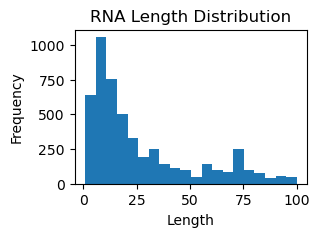

Mean Length: 17.436723580464008
Median Length: 15
Standard Deviation: 11.275555969068634


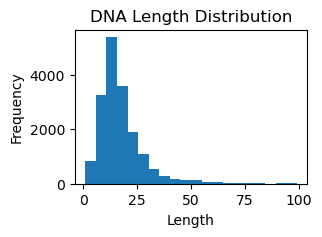

#RNA within cutoff:  5038
#DNA within cutoff:  17629
#positive seq:  22667


In [8]:

with open('../Data/RNA_dataset.json', 'r') as file:
    RNA_dataset = json.load(file)
with open('../Data/DNA_dataset.json', 'r') as file:
    DNA_dataset = json.load(file)

## check the length distribution of RNA and DNA ##
import matplotlib.pyplot as plt

RNA_lengths = []
DNA_lengths = []
len_cutoff = 100
positive_seq = []

for key, value in RNA_dataset.items():
    for chain_id, seq in value.items():
        length = len(seq)
        if length > len_cutoff:
            continue
        RNA_lengths.append(length)
        positive_seq.append(seq)
for key, value in DNA_dataset.items():
    for chain_id, seq in value.items():
        length = len(seq)
        if length > len_cutoff:
            continue
        DNA_lengths.append(length)
        positive_seq.append(seq)

def plot_distribution(lengths, title):
    mean_length = sum(lengths) / len(lengths)
    median_length = sorted(lengths)[len(lengths) // 2]
    std_dev_length = (sum([(x - mean_length) ** 2 for x in lengths]) / len(lengths)) ** 0.5

    print(f"Mean Length: {mean_length}")
    print(f"Median Length: {median_length}")
    print(f"Standard Deviation: {std_dev_length}")

    plt.figure(figsize=(3, 2))
    plt.hist(lengths, bins=20)
    plt.title(title)
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.show()

plot_distribution(RNA_lengths, 'RNA Length Distribution')
plot_distribution(DNA_lengths, 'DNA Length Distribution')
print('#RNA within cutoff: ', len(RNA_lengths))
print('#DNA within cutoff: ', len(DNA_lengths))
print('#positive seq: ', len(positive_seq))

In [58]:
## reverse translate protein sequence to RNA sequence as negative sample ##

with open('../Data/prot_dataset.json', 'r') as file:
    prot_dataset = json.load(file)

rev_translation_RNA_dataset = {}
negative_seq = []
len_cutoff = 10 ## cutoff for protein length, as the mean length of RNA is about 25
sample_num = 2 ## how many negative samples to generate for each long protein sequence

mean_length = 7
std_length = 5

for key, value in prot_dataset.items():
    for chain_id, seq in value.items():
        selected_seq = []
        if '-' in seq: ## skip the sequence with gap
            continue

        if len(seq) < len_cutoff:
            selected_seq.append(seq)
        elif len(seq) > len_cutoff*6:
            seq_len = int(np.random.normal(mean_length, std_length))
            if seq_len <= 0:
                continue
            selected_seq.extend(random_substring(seq, seq_len, sample_num))
        
        for prot in selected_seq:
            RNA_seq = reverse_translate(prot)
            negative_seq.append(RNA_seq)
        '''
        if key not in rev_translation_RNA_dataset:
            rev_translation_RNA_dataset[key] = []
        rev_translation_RNA_dataset[key].append(RNA_seq)
        negative_seq.append(RNA_seq)
        '''
print('#negative seq: ', len(negative_seq))

#negative seq:  14600


Mean Length: 19.540080292936867
Median Length: 15
Standard Deviation: 15.927304216041064


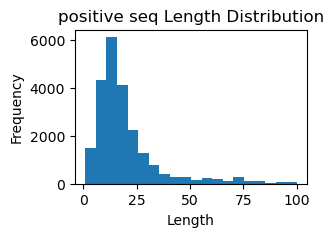

Mean Length: 22.469794520547946
Median Length: 21
Standard Deviation: 12.470580940712994


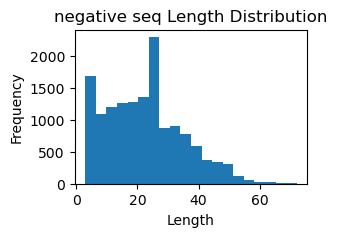

In [59]:
len_pos = [len(seq) for seq in positive_seq]
len_neg = [len(seq) for seq in negative_seq]

plot_distribution(len_pos, 'positive seq Length Distribution')
plot_distribution(len_neg, 'negative seq Length Distribution')

In [60]:
## save positive and negative dataset to json file ##
with open('../Data/positive_seq.json', 'w') as file:
    json.dump(positive_seq, file)
with open('../Data/negative_seq.json', 'w') as file:
    json.dump(negative_seq, file)